# Impact Detection

In [56]:
# imports
import os
import json
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

## Load Pose Estimates

In [48]:
# function to interpolate missing pose estimates
# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def interpolate_pose_estimates(a):
    found = a != 0
    not_found = a == 0
    xp = found.nonzero()[0]
    fp = a[found]
    x  = not_found.nonzero()[0]

    a[not_found] = np.interp(x, xp, fp)
    return a

# function to load pose estimates
def load_pose_estimates(load_dir, vid_name, fps):
    json_files = sorted(os.listdir(os.path.join(load_dir, vid_name)))
    json_paths = [(int(json_file.split('_')[1]), os.path.join(load_dir, vid_name, json_file)) for json_file in json_files if '.json' in json_file]
    n_frames = len(json_paths)
    
    pose_x = np.empty((n_frames, 18))
    pose_y = np.empty((n_frames, 18))
    pose_c = np.empty((n_frames, 18))
    time_stamps = np.empty((n_frames))
    for frm, json_path in json_paths: 
        with open(json_path, 'r') as f:
            json_dict = json.load(f)
        x = json_dict['people'][0]['pose_keypoints_2d'][0::3]
        y = json_dict['people'][0]['pose_keypoints_2d'][1::3]
        c = json_dict['people'][0]['pose_keypoints_2d'][2::3]
        pose_x[frm] = x
        pose_y[frm] = y
        pose_c[frm] = c
        time_stamps[frm] = frm/fps
        
    # interpolate missing pose estimates
    for limb in range(18):
        pose_x[:,limb] = interpolate_pose_estimates(pose_x[:,limb])
        pose_y[:,limb] = interpolate_pose_estimates(pose_y[:,limb])
        
    print(f'Interpolation correct?: {(pose_x != 0).all() and (pose_y != 0).all()}')
        
    return pose_x, pose_y, pose_c, time_stamps

In [49]:
# load pose estimates for j1
load_dir = os.path.join('data', 'output_jsons')
vid_name = 'j1'
fps = 30

pose_x, pose_y, pose_c, time_stamps = load_pose_estimates(load_dir, vid_name, fps)
pose_x.shape, pose_y.shape, pose_c.shape, time_stamps.shape

Interpolation correct?: True


((4606, 18), (4606, 18), (4606, 18), (4606,))

## Detect Impact Points

https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_02_output.html

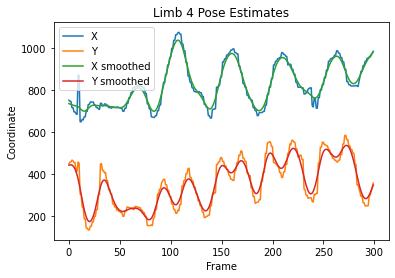

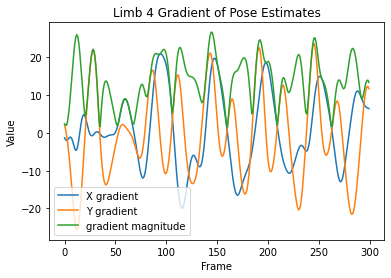

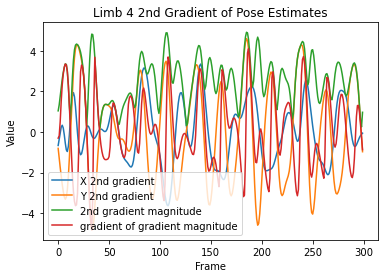

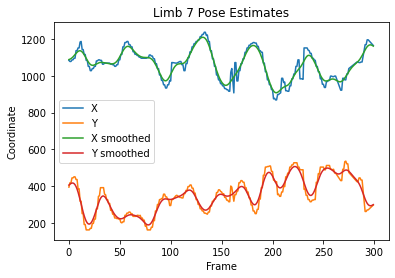

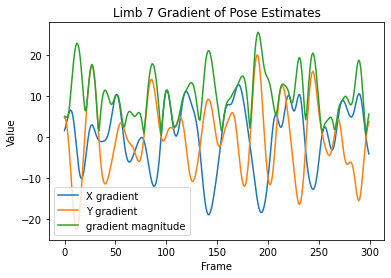

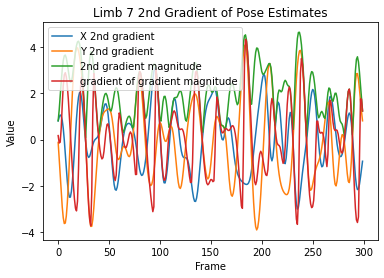

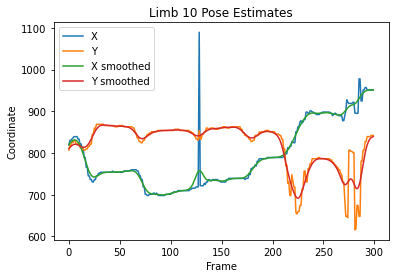

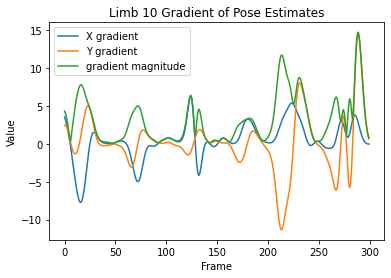

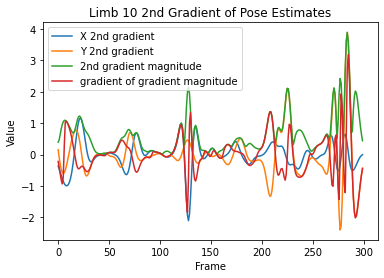

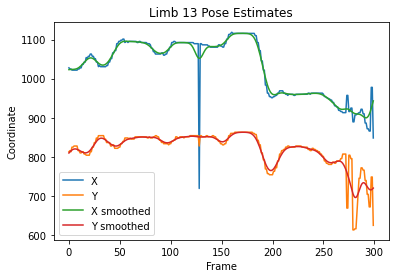

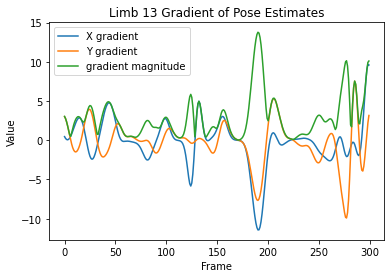

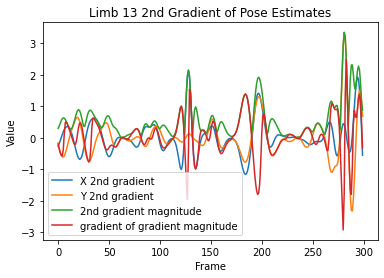

(array([3.38688667, 1.88884064, 2.34476769, 2.27963526]), (4606, 4), (4606,))

In [101]:
# function to detect impact points
def detect_impact_points(pose_x, pose_y, pose_c, time_stamps, limb_indices, thresholds, show_plots=False):
    assert len(pose_x) == len(pose_y) and len(pose_x) == len(pose_c) and len(pose_x) == len(time_stamps)
    
    # detect impact points for each limb
    n_frames = len(time_stamps)
    n_limbs = len(limb_indices)
    impact_points = np.zeros((n_frames, n_limbs), dtype=bool)
    for i, limb in enumerate(limb_indices):
        x = pose_x[:,limb]
        y = pose_y[:,limb]
        c = pose_c[:,limb] # just a confidence value, probably not necessary
        limb_impacts = np.zeros((n_frames), dtype=bool)
        
        # to do: detect impact points here
        sigma = 4
        x_filt = gaussian_filter1d(x, sigma)
        y_filt = gaussian_filter1d(y, sigma)
        x_grad = np.gradient(x_filt)
        y_grad = np.gradient(y_filt)
        mag_grad = np.sqrt(x_grad**2 + y_grad**2)
        x_grad2 = np.gradient(x_grad)
        y_grad2 = np.gradient(y_grad)
        mag_grad2 = np.sqrt(x_grad2**2 + y_grad2**2)
        mag_grad_grad = np.gradient(mag_grad)
        
        if show_plots:
            start_second = 60
            num_seconds = 10
            start_i = 30 * start_second
            end_i = start_i + 30 * num_seconds
            
            plt.plot(x[start_i:end_i], label='X')
            plt.plot(y[start_i:end_i], label='Y')
            plt.plot(x_filt[start_i:end_i], label='X smoothed')
            plt.plot(y_filt[start_i:end_i], label='Y smoothed')
            plt.title(f'Limb {limb} Pose Estimates')
            plt.xlabel('Frame')
            plt.ylabel('Coordinate')
            plt.legend()
            plt.show()

            plt.plot(x_grad[start_i:end_i], label='X gradient')
            plt.plot(y_grad[start_i:end_i], label='Y gradient')
            plt.plot(mag_grad[start_i:end_i], label='gradient magnitude')
            plt.title(f'Limb {limb} Gradient of Pose Estimates')
            plt.xlabel('Frame')
            plt.ylabel('Value')
            plt.legend()
            plt.show()

            plt.plot(x_grad2[start_i:end_i], label='X 2nd gradient')
            plt.plot(y_grad2[start_i:end_i], label='Y 2nd gradient')
            plt.plot(mag_grad2[start_i:end_i], label='2nd gradient magnitude')
            plt.plot(mag_grad_grad[start_i:end_i], label='gradient of gradient magnitude')
            plt.title(f'Limb {limb} 2nd Gradient of Pose Estimates')
            plt.xlabel('Frame')
            plt.ylabel('Value')
            plt.legend()
            plt.show()
            
        limb_impacts[mag_grad_grad <= thresholds[i]] = True
        impact_points[:,i] = limb_impacts
    
    assert len(impact_points) == len(time_stamps)
    return impact_points, time_stamps

# testing
show_plots = True
limb_indices = [4, 7, 10, 13] # hands and feet indices in COCO format
thresholds = [-2, -2, -1, -1]
impact_points, time_stamps = detect_impact_points(pose_x, pose_y, pose_c, time_stamps, limb_indices, thresholds, show_plots=show_plots)
100 * impact_points.mean(axis=0), impact_points.shape, time_stamps.shape

In [102]:
# save results to file
save_dir = os.path.join('data', 'impact_points')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

np.save(os.path.join(save_dir, f'{vid_name}_impact_points.npy'), impact_points)
np.save(os.path.join(save_dir, f'{vid_name}_time_stamps.npy'), time_stamps)

## Run on All Videos

In [6]:
# run impact detection for all videos
load_dir = os.path.join('data', 'output_jsons')
vid_info_df = pd.read_csv(os.path.join('video', 'video_info.csv'), index_col='vid_name')
limb_indices = [4, 7, 10, 13] # hands and feet indices in COCO format

save_dir = os.path.join('data', 'impact_points')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# iterate over all videos
for vid_name in vid_info_df.index:
    if vid_name != 'group':
        print(10 * '-')
        print(vid_name)
        
        # load pose estimates
        fps = vid_info_df.loc[vid_name]['fps']
        pose_x, pose_y, pose_c, time_stamps = load_pose_estimates(load_dir, vid_name, fps)
        
        # detect and save impact points and timestamps
        impact_points, time_stamps = detect_impact_points(pose_x, pose_y, pose_c, time_stamps, limb_indices)
        np.save(os.path.join(save_dir, f'{vid_name}_impact_points.npy'), impact_points)
        np.save(os.path.join(save_dir, f'{vid_name}_time_stamps.npy'), time_stamps)

----------
a1
----------
a2
----------
e1
----------
e2
----------
e3
----------
j1
----------
j2
----------
u1
----------
u2
